# Permutation Feature-based Frequency Response Analysis
## A brief tutorial for PFFRA-v1.0.2

In [1]:
import PFFRA
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

### 1. Basic usage example of applying Fourier transform-based PFFRA

#### Generate synthetic data for regression

In [2]:
# Generate a simple synthetic dataset
t = np.linspace(0,10,1000)
x1 = np.sin(2 * np.pi * 10 * t)
x2 = np.sin(2 * np.pi * 37 * t)
x3 = np.cos(2* np.pi * 39 * t)

X = np.vstack((x1, x2, x3)).T
y = 5*x1+2*x2+3*x3

#### Show the generated features and target

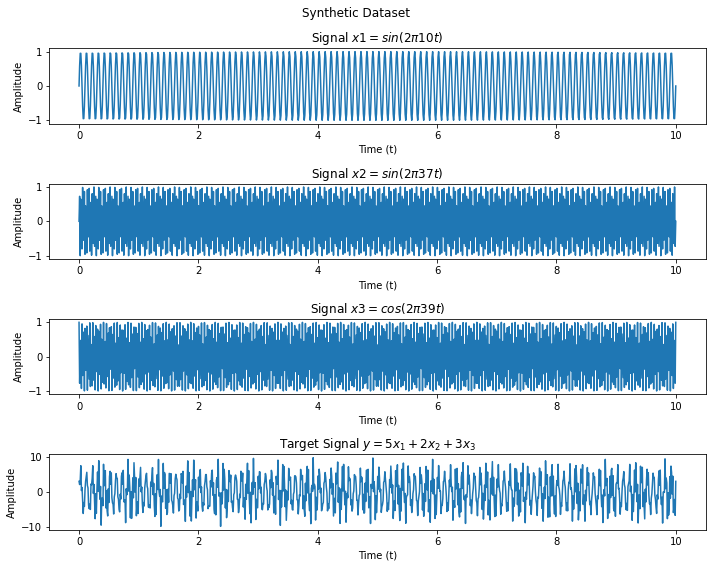

In [3]:
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

axs[0].plot(t, x1)
axs[0].set_title(r'Signal $x1 = sin(2\pi 10 t)$')
axs[0].set_xlabel('Time (t)')
axs[0].set_ylabel('Amplitude')

axs[1].plot(t, x2)
axs[1].set_title(r'Signal $x2 = sin(2\pi 37 t)$')
axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel('Amplitude')

axs[2].plot(t, x3)
axs[2].set_title(r'Signal $x3 = cos(2\pi 39 t)$')
axs[2].set_xlabel('Time (t)')
axs[2].set_ylabel('Amplitude')

axs[3].plot(t, y)
axs[3].set_title(r'Target Signal $y = 5x_1 + 2x_2 + 3x_3$')
axs[3].set_xlabel('Time (t)')
axs[3].set_ylabel('Amplitude')

plt.suptitle('Synthetic Dataset')
plt.tight_layout()
plt.show()

#### Train a XGBM model and generate predictions

In [4]:
model = XGBRegressor(n_estimators = 10)
model = model.fit(X, y)
y_hat = model.predict(X)

#### Compare predictions and the ground truth

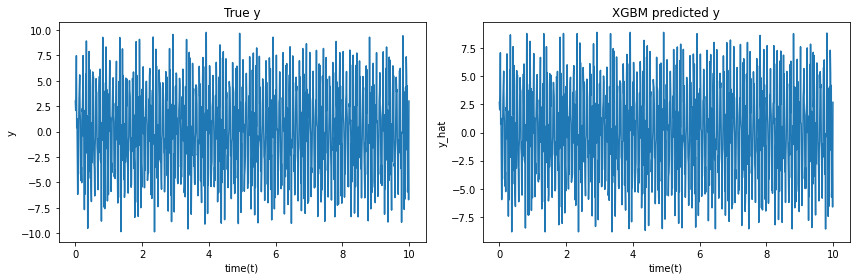

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(t, y)
axs[0].set_title("True y")
axs[0].set_xlabel("time(t)")
axs[0].set_ylabel("y")
axs[1].plot(t, y_hat)
axs[1].set_title("XGBM predicted y")
axs[1].set_xlabel("time(t)")
axs[1].set_ylabel("y_hat")
plt.tight_layout()
plt.show()

#### Apply PFFRA (Fourier Transform)
##### Draw spectrum figures directly for a given interested feature index
By instantiating class ``PermFeatureFreqRespoAnalysis`` to specify the feature index as 1, we are able to call ``show_spectrum()`` to draw the graph that compares the spectrums with the feature $x_1$ and other features are permuted by thier mean values. The lower subfigure shows the frequency response using the original dataset with all features. 

In this example, we use ``mean`` value to permute the wanted feature.

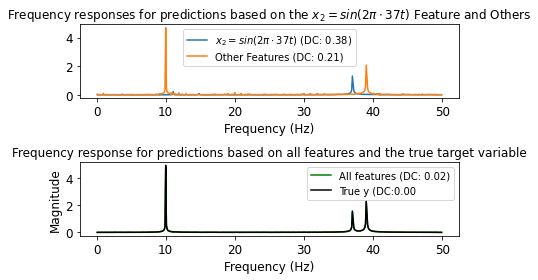

In [6]:
pffra = PFFRA.PermFeatureFreqRespoAnalysis(y = y, X = X, model = model, 
                                           interested_feature_index = 1)
pffra.show_spectrum(sample_rate = 100, mode = 'mean', rename_feature = r"$x_2=sin(2\pi\cdot37t)$")

##### Investigate multiple features and output their permutation spectrum data
Calling ``gen_spectrum()`` method allows us to get access to the spectrum data for any feature.

In this example, we ``shuffle`` the values for the wanted feature for the permutation purpose.

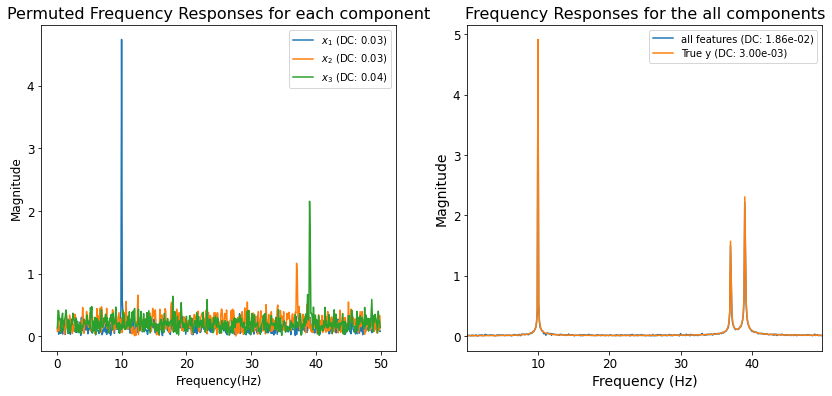

In [7]:
fig = plt.figure(figsize = (14,6))
ax1 = fig.add_subplot(121)
for i in range(X.shape[1]):
    # instantiate PFFRA
    pffra = PFFRA.PermFeatureFreqRespoAnalysis(y = y, X = X, model = model, interested_feature_index = i)
    # Generate permutation dataset
    X_interested_feature, X_other_feature = pffra.permuted_dataset(mode = 'shuffle')
    # Predict target variables using the permutated datasets
    pred_interested_feature, pred_other_feature, pred_all_feature = pffra.permu_pred(X_interested_feature, X_other_feature)
    # Generate spectrums for analysis
    spectrums = pffra.gen_spectrum(pred_interested_feature = pred_interested_feature, 
                                   pred_other_feature = pred_other_feature, 
                                   pred_all_feature = pred_all_feature, 
                                   sample_rate = 100)
    # Unpack spectrums
    spectrum_interested_i = spectrums[0]
    spectrum_all = spectrums[2]
    spectrum_true = spectrums[3]
    frq_range = spectrums[4]
    
    plt.rcParams["axes.labelsize"] = 14
    plt.rcParams["axes.titlesize"] = 16  
    plt.rcParams["xtick.labelsize"] = "large"
    plt.rcParams["ytick.labelsize"] = "large"
    ax1.plot(frq_range[1:], spectrum_interested_i[1:], 
             label = r"$x_{}$ (DC: {:.2f})".format(i+1, spectrum_interested_i[0]))
    ax1.legend()
    ax1.set_xlabel("Frequency(Hz)")
    ax1.set_ylabel("Magnitude")
    ax1.set_title("Permuted Frequency Responses for each component")

ax2 = fig.add_subplot(122)
ax2.plot(frq_range[1:], spectrum_all[1:], 
         label = "{} (DC: {:.2e})".format("all features", spectrum_all[0]))
ax2.plot(frq_range[1:], spectrum_true[1:], 
         label = "{} (DC: {:.2e})".format("True y", spectrum_true[0]))
ax2.legend()
ax2.set_xlim(frq_range[1], frq_range[-1])
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Magnitude")
ax2.set_title("Frequency Responses for the all components")
plt.show()

### 2. Advanced usage example of applying wavelet transform-based PFFRA

#### Generate synthetic data for regression

In [8]:
t = np.linspace(0, 2, 2000)
w1 = 3*t**2 + 10
w2 = -5*t + 50
w3 = 100
x1 = np.sin(2 * np.pi * w1 * t)
x2 = np.sin(2 * np.pi * w2 * t)
x3 = np.cos(2 * np.pi * w3 * t)

X = np.column_stack((x1, x2, x3))
y = 3 * x1 + 2 * x2 + 4*x3

#### Show the generated features and target

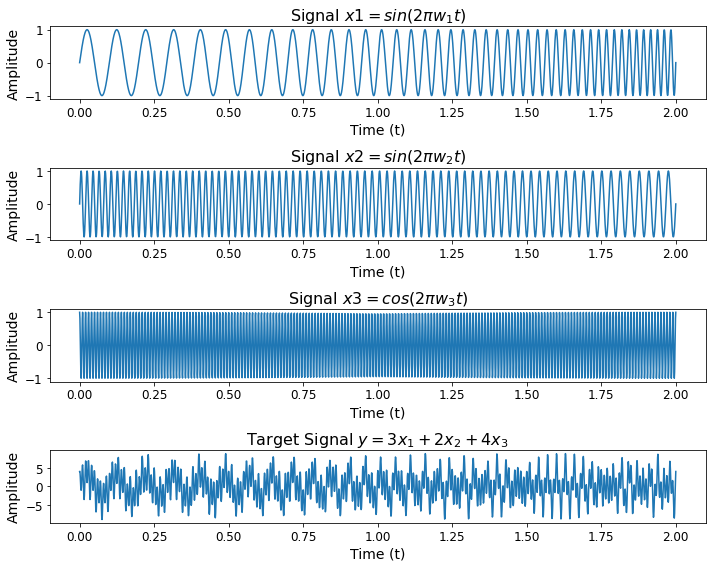

In [9]:
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

axs[0].plot(t, x1)
axs[0].set_title(r'Signal $x1 = sin(2\pi w_1 t)$')
axs[0].set_xlabel('Time (t)')
axs[0].set_ylabel('Amplitude')

axs[1].plot(t, x2)
axs[1].set_title(r'Signal $x2 = sin(2\pi w_2 t)$')
axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel('Amplitude')

axs[2].plot(t, x3)
axs[2].set_title(r'Signal $x3 = cos(2\pi w_3 t)$')
axs[2].set_xlabel('Time (t)')
axs[2].set_ylabel('Amplitude')

axs[3].plot(t, y)
axs[3].set_title(r'Target Signal $y = 3x_1 + 2x_2 + 4x_3$')
axs[3].set_xlabel('Time (t)')
axs[3].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

#### Train a XGBM model and generate predictions

In [10]:
model = XGBRegressor(n_estimators = 50)
model = model.fit(X, y)
y_hat = model.predict(X)

#### Compare predictions and the ground truth

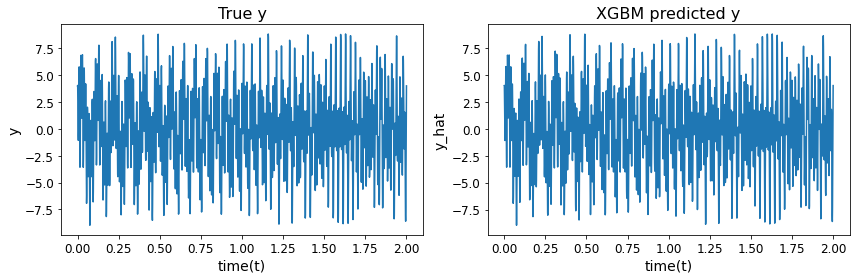

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(t, y)
axs[0].set_title("True y")
axs[0].set_xlabel("time(t)")
axs[0].set_ylabel("y")
axs[1].plot(t, y_hat)
axs[1].set_title("XGBM predicted y")
axs[1].set_xlabel("time(t)")
axs[1].set_ylabel("y_hat")
plt.tight_layout()
plt.show()

#### Apply PFFRA (Wavelet Transform)
##### Draw wavelet figures directly for a given interested feature index

By instantiating class ``PermFeatureFreqRespoAnalysis`` to specify the feature index as 1, we are able to call ``show_wavelet()`` to draw the graph that compares the spectrums with the feature $x_1$ and other features are permuted by thier mean values. 

Note that choosing an appropriate ``wavelet`` and its ``center frequency`` and ``bandwidth`` is important. Meanwhile, designating an appropriate ``freqency range`` is also important for demonstration.

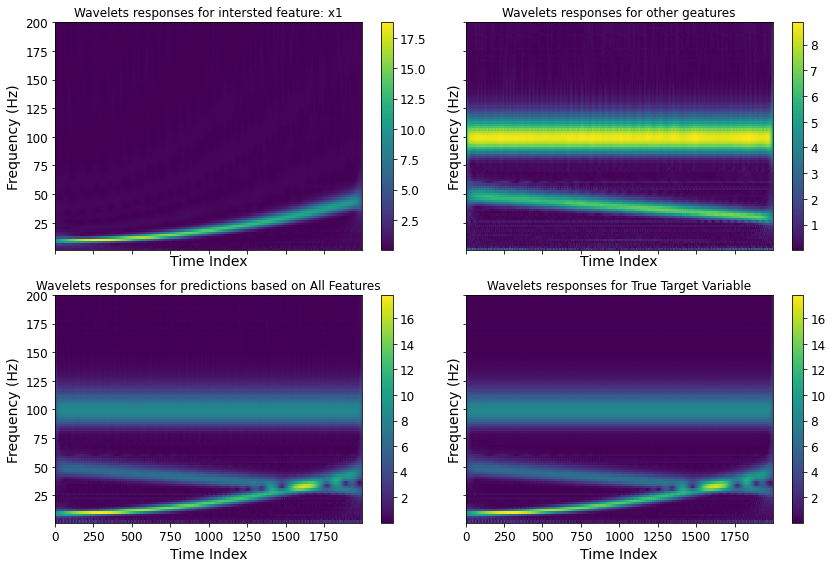

In [12]:
pffra = PFFRA.PermFeatureFreqRespoAnalysis(y = y, X = X, model = model, 
                                     interested_feature_index = 0)
pffra.show_wavelet(sample_rate = 1000, mode = 'mean', 
                   freq_range = np.linspace(200, 1, 100), wavelet = "cmor1.3-1.8",
                   rename_feature = "x1")

##### Investigate multiple features and output their permutation wavelets
Calling ``gen_wavelet()`` method allows us to get access to the wavelets for any wanted feature.

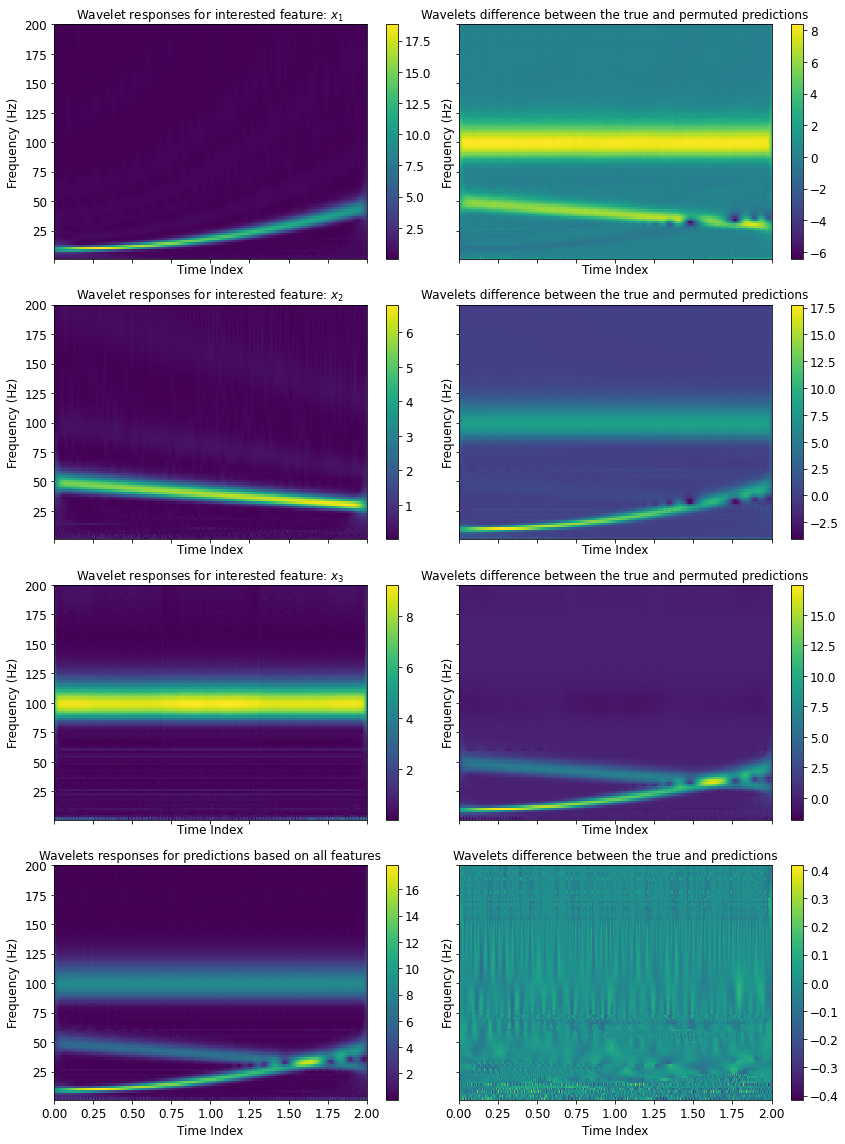

In [13]:
fig, axs = plt.subplots(4, 2, figsize=(12, 16), sharex=True, sharey=True)
time_index = np.linspace(0, 2, len(y))
freq_range = np.linspace(200, 1, 100)
for i in range(X.shape[1]):
    # instantiate PFFRA
    pffra = PFFRA.PermFeatureFreqRespoAnalysis(y = y, X = X, model = model, interested_feature_index = i)
    # Generate permutation dataset
    X_interested_feature, X_other_feature = pffra.permuted_dataset(mode = 'mean')
    # Predict target variables using the permutated datasets
    pred_interested_feature, pred_other_feature, pred_all_feature = pffra.permu_pred(X_interested_feature, X_other_feature)
    # Generate spectrums for analysis
    wavelets_freq = pffra.gen_wavelet(pred_interested_feature = pred_interested_feature, 
                                      pred_other_feature = pred_other_feature, 
                                      pred_all_feature = pred_all_feature, 
                                      sample_rate = 1000, freq_range = np.linspace(200, 1, 100), wavelet = "cmor1.3-1.8")
    # Unpack spectrums
    wavelet_interested_i = wavelets_freq[0]
    wavelet_others = wavelets_freq[1]
    wavelet_all = wavelets_freq[2]
    wavelet_true = wavelets_freq[3]
    frq_range = wavelets_freq[4]
    
    plt.rcParams["axes.labelsize"] = 12
    plt.rcParams["axes.titlesize"] = 12
    plt.rcParams["xtick.labelsize"] = "large"
    plt.rcParams["ytick.labelsize"] = "large"
    
    axs[i, 0].set_xlabel("Time Index")
    axs[i, 0].set_ylabel("Frequency (Hz)")
    pcm = axs[i, 0].pcolormesh(time_index, freq_range, wavelet_interested_i)
    axs[i, 0].set_title("Wavelet responses for interested feature: {}".format(r"$x_{}$".format(i+1))) 
    plt.colorbar(pcm, ax=axs[i, 0])
    
    axs[i, 1].set_xlabel("Time Index")
    axs[i, 1].set_ylabel("Frequency (Hz)")
    pcm = axs[i, 1].pcolormesh(time_index, freq_range, wavelet_true - wavelet_interested_i)
    axs[i, 1].set_title("Wavelets difference between the true and permuted predictions")
    plt.colorbar(pcm, ax=axs[i, 1])
    
axs[3, 0].set_xlabel("Time Index")
axs[3, 0].set_ylabel("Frequency (Hz)")
pcm = axs[3, 0].pcolormesh(time_index, freq_range, wavelet_all)
axs[3, 0].set_title("Wavelets responses for predictions based on all features")
plt.colorbar(pcm, ax=axs[3, 0])

axs[3, 1].set_xlabel("Time Index")
axs[3, 1].set_ylabel("Frequency (Hz)")
pcm = axs[3, 1].pcolormesh(time_index, freq_range, wavelet_true - wavelet_all)
axs[3, 1].set_title("Wavelets difference between the true and predictions")
plt.colorbar(pcm, ax=axs[3, 1])

plt.tight_layout()
